- year to year analysis DONE
- month to month analysis DONE
- quarter to quarter analysis
- a total analysis
- VU Rides on each of the bus ride types
- monthly ridership per each route and the top 6 routes
- employee analysis (routes and yearly/monthly)
- student analysis (routes and yearly/monthly)

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import io

In [20]:
# Array of CSV files
csv_files = ["MoveVU_2017_2020.csv", "MoveVU_2020_2022.csv", "MoveVU_2022_Oct2023.csv"]

df1 = pd.read_csv(csv_files[0], usecols=["ROUTE", "CARDOFFICE_CARD_NUMBER", "CARD_ID_STATUS", "RIDE_DATE", "BUS", "ROUTE", "RUN", "RT_AREA", "RTA_COUNT", "WEGO_COUNT", "FIRST_NAME", "LAST_NAME", "EMPLOYEE_OR_STUDENT", "CAMPUS_ID"])

df2 = pd.read_csv(csv_files[1], usecols=["ROUTE", "CARDOFFICE_CARD_NUMBER", "FIRST_NAME", "LAST_NAME", "EMPLOYEE_OR_STUDENT", "CARD_ID_STATUS", "RIDE_DATE", "BUS", "ROUTE", "RUN", "RT_AREA", "CAMPUS_ID", "RTA_COUNT", "WEGO_COUNT"])

df3 = pd.read_csv(csv_files[2], usecols=["ROUTE", "CARDOFFICE_CARD_NUMBER", "FIRST_NAME", "LAST_NAME", "EMPLOYEE_OR_STUDENT", "CARD_ID_STATUS", "RIDE_DATE", "BUS", "ROUTE", "RUN", "RT_AREA", "CAMPUS_ID", "RTA_COUNT", "WEGO_COUNT"])

frames = [df1, df2, df3]
df = pd.concat(frames, ignore_index=True)

# Converting the "RIDE_DATE" columns to datetime objects
df['RIDE_DATE'] = pd.to_datetime(df['RIDE_DATE'])

print("Data Fields:", df.columns.values)
print("Total Number of Vanderbilt Scans in the We Go Bus System:", df.shape[0])

Data Fields: ['CARDOFFICE_CARD_NUMBER' 'CARD_ID_STATUS' 'RIDE_DATE' 'BUS' 'ROUTE' 'RUN'
 'RT_AREA' 'RTA_COUNT' 'WEGO_COUNT' 'FIRST_NAME' 'LAST_NAME'
 'EMPLOYEE_OR_STUDENT' 'CAMPUS_ID']
Total Number of Vanderbilt Scans in the We Go Bus System: 1773392


In [21]:
# Finding the minimum and maximum dates in the dataset
min_date = df['RIDE_DATE'].min()
max_date = df['RIDE_DATE'].max()

print(min_date)
print(max_date)

2017-01-01 06:54:00+00:00
2023-09-30 22:42:19+00:00


In [22]:
# Setting up Nashville's Bus Route as a Dictionary

WEGO_FREQUENT_SERVICE = {
    3: "West_End",
    22: "Bordeaux",
    23: "Dickerson_Pike",
    50: "Charlotte_Pike",
    52: "Nolansville_Pike",
    55: "Murfreesboro_Pike",
    56: "Gallatin_Pike"
}

WEGO_LOCAL_SERVICE = {
    4: "Shelby",
    6: "Lebanon_Pike",
    7: "Hillsboro_Pike",
    8: "8th_Avenue_South",
    9: "MetroCenter",
    14: "Whites_Creek",
    17: "12th_Avenue_South",
    18: "Airport",
    19: "Herman",
    28: "Meridian",
    29: "Jefferson",
    34: "Opry Mills",
    41: "Golden Valley",
    42: "St._Cecilia/Cumberland"
}

WEGO_CONNECTOR_SERVICE = {
    70: "Bellevue",
    75: "Midtown",
    76: "Madison",
    77: "Thompson/Wedgewood",
    79: "Skyline"
}

WEGO_EXPRESS_SERVICE = {
    84: "Murfreesboro",
    86: "Smyrna/La_Vergne",
    87: "Gallatin/Hendersonville",
    88: "Dickson",
    89: "Springfield/Joelton",
    94: "Clarksville",
    95: "Spring_Hill/Franklin"
}

# TODO need to find the number for the train system and other missing routes
WEGO_TRAIN_SERVICE = {
    64: "Star_Downtown_Shuttle",
    93: "Star_West_End_Shuttle"
}

WEGO_ALL_ROUTES = {**WEGO_FREQUENT_SERVICE, **WEGO_LOCAL_SERVICE, **WEGO_CONNECTOR_SERVICE, **WEGO_EXPRESS_SERVICE, **WEGO_TRAIN_SERVICE}
list_WE_GO_ALL_ROUTES = list(WEGO_ALL_ROUTES.keys())
list_WE_GO_ALL_ROUTES.sort()
print("Listed Routes:", list_WE_GO_ALL_ROUTES)
print("Number of Routes:", len(list_WE_GO_ALL_ROUTES))


# checking unique routes from the data
unique_routes = list(df['ROUTE'].unique())
unique_routes.sort()
print("Unique Routes:", unique_routes)
set_unique_routes = set(unique_routes)
print("Number of Unique Routes:", len(set_unique_routes))
# seeing what routes are missing from the dictionary
missing_routes_set = set_unique_routes - set(list_WE_GO_ALL_ROUTES)
missing_routes = list(missing_routes_set)
missing_routes.sort()
print("Missing Routes:", missing_routes)
print("Number of Missing Routes:", len(missing_routes))


# Possible Explanation for Missing Routes:
# Missing Routes: [16, 27, 47, 48, 59, 97, 98, 99]
# 16: Old Hickory - Independent section became part of an extended 36 Madison Square
# 16: Madison/Old Hickory - Created on August 10, 2003; eliminated due to budget crisis; service restored in Madison on September 26, 2010, as 76 Madison Connector; rest restored on April 30, 2012, as 27 Old Hickory (eastern portion) and 36 Madison Express (western portion)
# 27: Opryland Hotel
# 27: Old Hickory
# 47: 
# 48:
# 59:
# 97:
# 98:
# 99:

Listed Routes: [3, 4, 6, 7, 8, 9, 14, 17, 18, 19, 22, 23, 28, 29, 34, 41, 42, 50, 52, 55, 56, 64, 70, 75, 76, 77, 79, 84, 86, 87, 88, 89, 93, 94, 95]
Number of Routes: 35
Unique Routes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 33, 34, 35, 36, 37, 38, 41, 42, 43, 44, 46, 47, 48, 50, 52, 53, 55, 56, 59, 60, 61, 64, 70, 72, 73, 75, 76, 77, 78, 79, 84, 86, 87, 88, 89, 91, 92, 93, 94, 95, 96, 97, 98, 99, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 180, 181, 183, 184, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 302, 303, 304, 311, 312, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 350, 352, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 

Total VU Rides on WeGo - year to year comparison (2017 - 2023)
List of Unique Years [2017, 2018, 2019, 2020, 2021, 2022, 2023]
YEAR
2017    232946
2018    218884
2019    419448
2020    166313
2021    194829
2022    286060
2023    254912
Name: Rides Per Year, dtype: int64


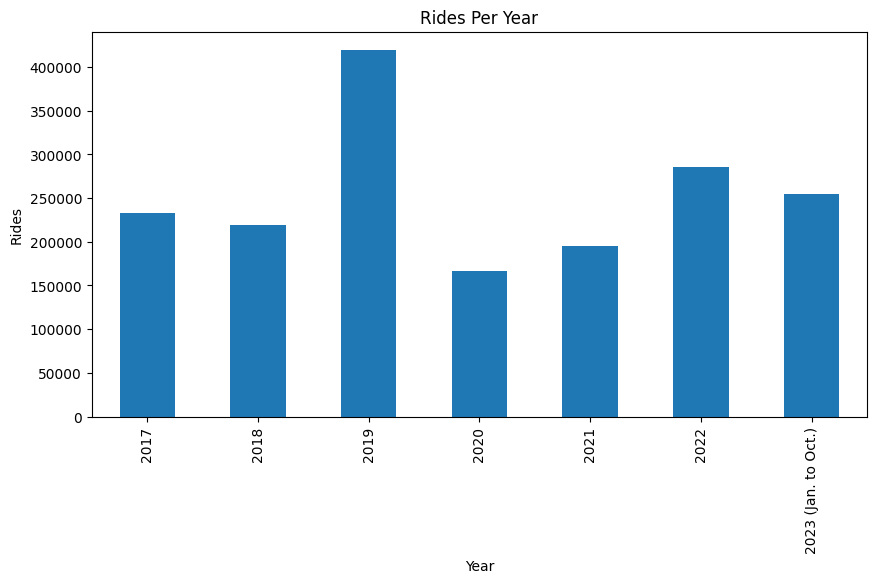

In [23]:
# yearly analysis of the data (2017 - October 2023)
# 2017: 1, 2018: 2, 2019: 3, 2020: 4, 2021: 5, 2022: 6, 2023: 7

# total VU Rides on WeGo - month to month comparison (2017 - October 2023)
print("Total VU Rides on WeGo - year to year comparison (2017 - 2023)")

# Extract the sum the year and month from the "RIDE_DATE" column
df['YEAR'] = df['RIDE_DATE'].dt.year

year_list = list(df['YEAR'].unique())
year_list.sort()

print("List of Unique Years", year_list)

# TODO: COMMENT THIS FUNCTION
def plot_all_years(rides):
    # set the header to "Total Rides"
    rides = rides.rename("Rides Per Year")
    print(rides)

    # Visualize the data
    plt.figure(figsize=(10, 5))
    rides.plot.bar()
    plt.title("Rides Per Year")
    plt.xlabel("Year")
    plt.ylabel("Rides")
    plt.xticks(range(len(rides)), ['2017', '2018', '2019', '2020', '2021', '2022', '2023 (Jan. to Oct.)'])
    plt.show()


# Group the data by year and calculate the total number of rides per month
all_yearly_rides = df.groupby('YEAR')['RIDE_DATE'].count()
plot_all_years(all_yearly_rides)

Monthly Analysis of the Data (2017 - Sept 2023)


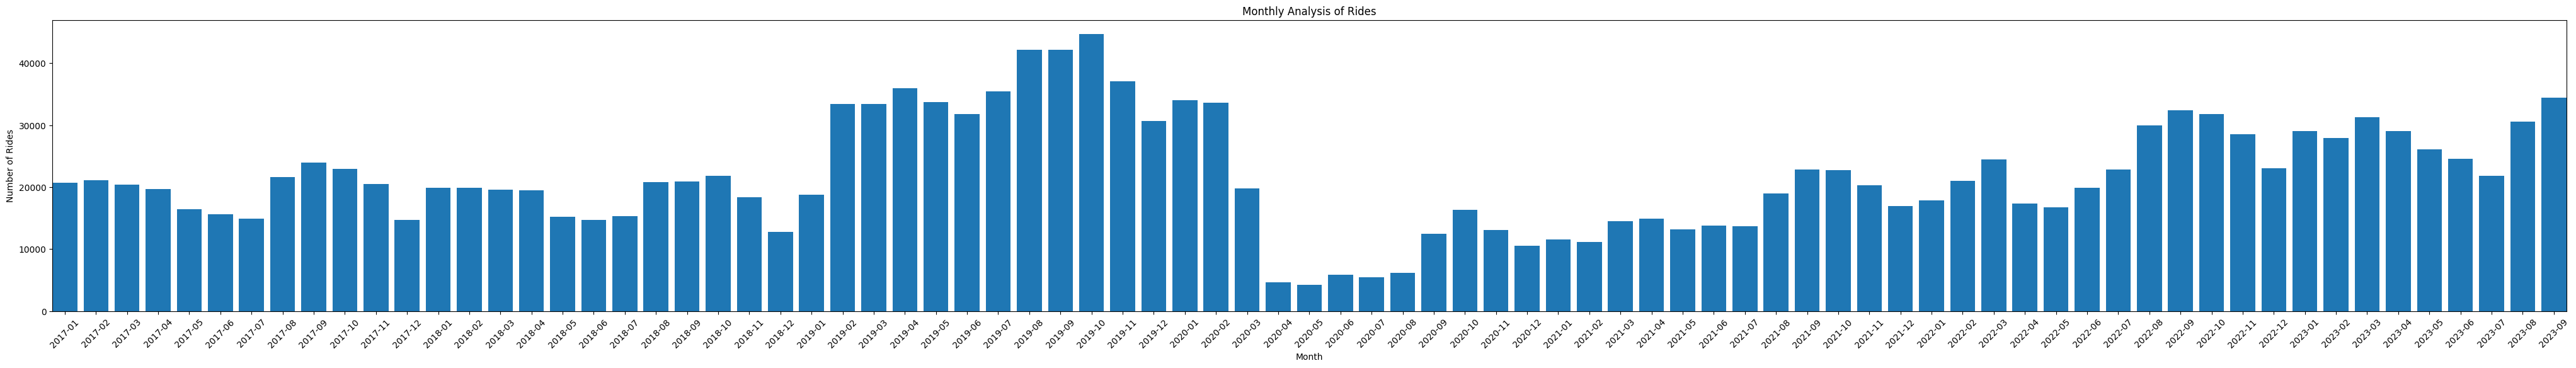

In [24]:
# monthly analysis of the data (2017 - October 2023)
print("Monthly Analysis of the Data (2017 - Sept 2023)")

# Extract month and year and create a new column
df['MONTH_YEAR'] = df['RIDE_DATE'].dt.strftime('%Y-%m')
# print(len(df['MONTH_YEAR'].unique()))


# print(monthly_data['MONTH_YEAR'].unique())

def plot_all_months(monthly_data):
    # Create a bar graph
    plt.figure(figsize=(10, 6))
    plt.bar(monthly_data['MONTH_YEAR'], monthly_data['RIDE_COUNT'])
    plt.xlabel('Month')
    plt.ylabel('Number of Rides')
    plt.title('Monthly Analysis of Rides')
    plt.xticks(rotation=45)  # Rotate x-axis labels for readability

    plt.gca().margins(x=0)
    plt.gcf().canvas.draw()
    tl = plt.gca().get_xticklabels()
    maxsize = max([t.get_window_extent().width for t in tl])
    m = 0.2 # inch margin
    s = maxsize/plt.gcf().dpi*(len(monthly_data))+2*m
    margin = m/plt.gcf().get_size_inches()[0]

    plt.gcf().subplots_adjust(left=margin, right=1.-margin)
    plt.gcf().set_size_inches(s, plt.gcf().get_size_inches()[1])

    # plt.savefig(__file__+".png")
    plt.show()

# Group the data by 'Month_Year' and count the number of rides per month
monthly_data = df.groupby('MONTH_YEAR').size().reset_index(name='RIDE_COUNT')
plot_all_months(monthly_data)


In [ ]:
# quarterly analysis of the data (2017 - October 2023)